#


# BTL1 môn Học Máy, mã môn học CO3117 - Học máy với dữ liệu bảng
## **Thông tin nhóm**

+ **Tên nhóm** : MLP2
+ **Giảng viên hướng dẫn**: TS. Lê Thành Sách
+ **Thành viên** :

    | **MSSV** | **Họ và tên** |
    |:---|:---:|
    | 2312046 | Bùi Ngọc Minh |
    | 2313233 | Lê Trọng Thiện |


## **Dataset**
Dữ liệu cho collab này bao gồm hơn 10k entries về các chi tiết của các mẫu xe, dùng để dự đoán giá thành của mẫu xe đó.

Dữ liệu này được lấy tại [kraggle](https://www.kaggle.com/datasets/CooperUnion/cardataset/data).

## **Nội dung**
File collab này áp dụng pipeline học máy truyền thống cho bộ dữ liệu, cùng với việc so sánh kết qủa dự đoán của các model học máy truyền thống.

# Chuẩn bị các thư viện



In [ ]:
import numpy as np
import pandas as pd
import os, random
import sklearn
import kagglehub
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
# models
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge # noted in requirements
from sklearn.svm import SVR # SVM - noted in requirements
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report



RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

#Chuẩn bị dữ liệu

In [ ]:
path = kagglehub.dataset_download("CooperUnion/cardataset")
print("Download and Load data at: " + path)

Using Colab cache for faster access to the 'cardataset' dataset.
Download and Load data at: /kaggle/input/cardataset




# Phân tích và xử lý dữ liệu

In [ ]:
df = pd.read_csv(path + '/data.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()



,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_fuel_type   11911 non-null  object 
 4   engine_hp          11845 non-null  float64
 5   engine_cylinders   11884 non-null  float64
 6   transmission_type  11914 non-null  object 
 7   driven_wheels      11914 non-null  object 
 8   number_of_doors    11908 non-null  float64
 9   market_category    8172 non-null   object 
 10  vehicle_size       11914 non-null  object 
 11  vehicle_style      11914 non-null  object 
 12  highway_mpg        11914 non-null  int64  
 13  city_mpg           11914 non-null  int64  
 14  popularity         11914 non-null  int64  
 15  msrp               11914 non-null  int64  
dtypes: float64(3), int64(5

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,11914.0,2010.384338,7.579740,1990.0,2007.0,2015.0,2016.00,2017.0
engine_hp,11845.0,249.386070,109.191870,55.0,170.0,227.0,300.00,1001.0
engine_cylinders,11884.0,5.628829,1.780559,0.0,4.0,6.0,6.00,16.0
number_of_doors,11908.0,3.436093,0.881315,2.0,2.0,4.0,4.00,4.0
highway_mpg,11914.0,26.637485,8.863001,12.0,22.0,26.0,30.00,354.0
city_mpg,11914.0,19.733255,8.987798,7.0,16.0,18.0,22.00,137.0
popularity,11914.0,1554.911197,1441.855347,2.0,549.0,1385.0,2009.00,5657.0
msrp,11914.0,40594.737032,60109.103604,2000.0,21000.0,29995.0,42231.25,2065902.0


In [ ]:
missing_data = df.isnull().sum() / len(df) * 100
print(missing_data)

make                  0.000000
model                 0.000000
year                  0.000000
engine_fuel_type      0.025180
engine_hp             0.579151
engine_cylinders      0.251805
transmission_type     0.000000
driven_wheels         0.000000
number_of_doors       0.050361
market_category      31.408427
vehicle_size          0.000000
vehicle_style         0.000000
highway_mpg           0.000000
city_mpg              0.000000
popularity            0.000000
msrp                  0.000000
dtype: float64


In [ ]:
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (715, 16)


In [ ]:
df=df.drop(columns=['market_category'])
df=df.dropna()
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11092 entries, 0 to 11913
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11092 non-null  object 
 1   model              11092 non-null  object 
 2   year               11092 non-null  int64  
 3   engine_fuel_type   11092 non-null  object 
 4   engine_hp          11092 non-null  float64
 5   engine_cylinders   11092 non-null  float64
 6   transmission_type  11092 non-null  object 
 7   driven_wheels      11092 non-null  object 
 8   number_of_doors    11092 non-null  float64
 9   vehicle_size       11092 non-null  object 
 10  vehicle_style      11092 non-null  object 
 11  highway_mpg        11092 non-null  int64  
 12  city_mpg           11092 non-null  int64  
 13  popularity         11092 non-null  int64  
 14  msrp               11092 non-null  int64  
dtypes: float64(3), int64(5), object(7)
memory usage: 1.4+ MB


In [ ]:
fig1 = px.histogram(df, x="msrp", nbins=50, title="MSRP Distribution")
fig1.show()

In [ ]:
#IRQ
Q1 = df["msrp"].quantile(0.25)
Q3 = df["msrp"].quantile(0.75)
IQR = Q3 - Q1

df = df[df["msrp"].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)]
print(df.shape)

(10146, 15)


In [ ]:

fig2 = px.histogram(df, x="msrp", nbins=50, title="MSRP Distribution")
fig2.show()

In [ ]:
df_nums = df.select_dtypes(include="number")
df_nums.head()

,year,engine_hp,engine_cylinders,number_of_doors,highway_mpg,city_mpg,popularity,msrp
0,2011,335.0,6.0,2.0,26,19,3916,46135
1,2011,300.0,6.0,2.0,28,19,3916,40650
2,2011,300.0,6.0,2.0,28,20,3916,36350
3,2011,230.0,6.0,2.0,28,18,3916,29450
4,2011,230.0,6.0,2.0,28,18,3916,34500


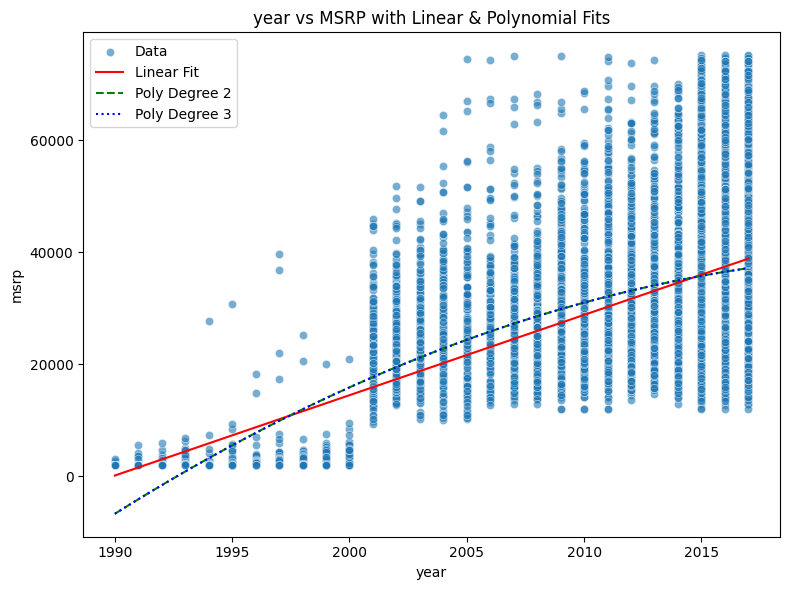

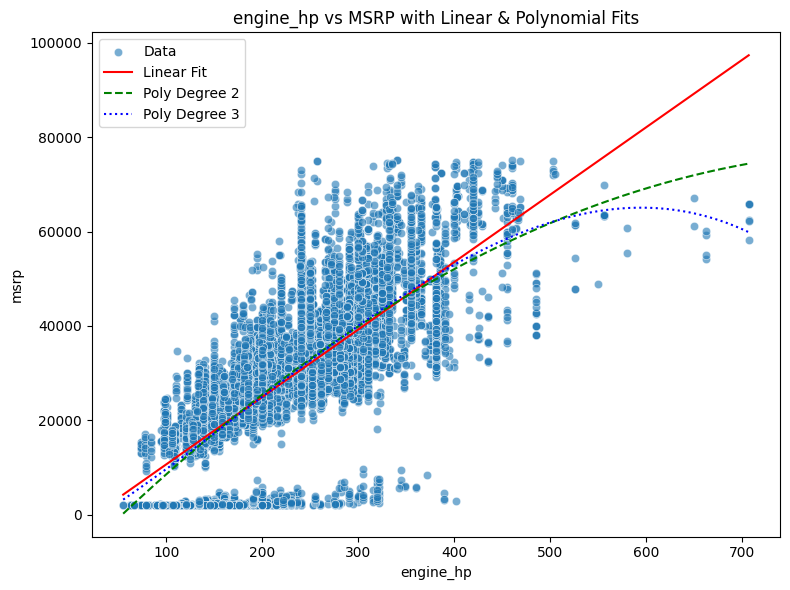

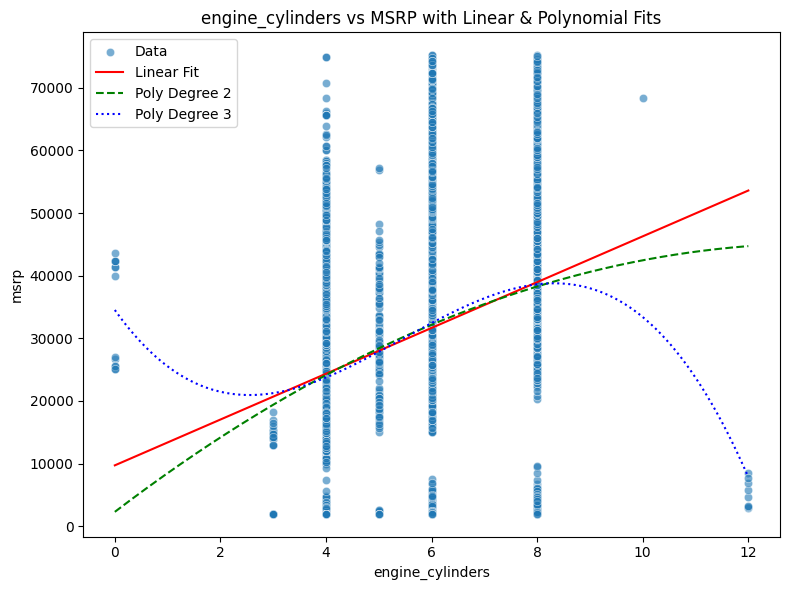

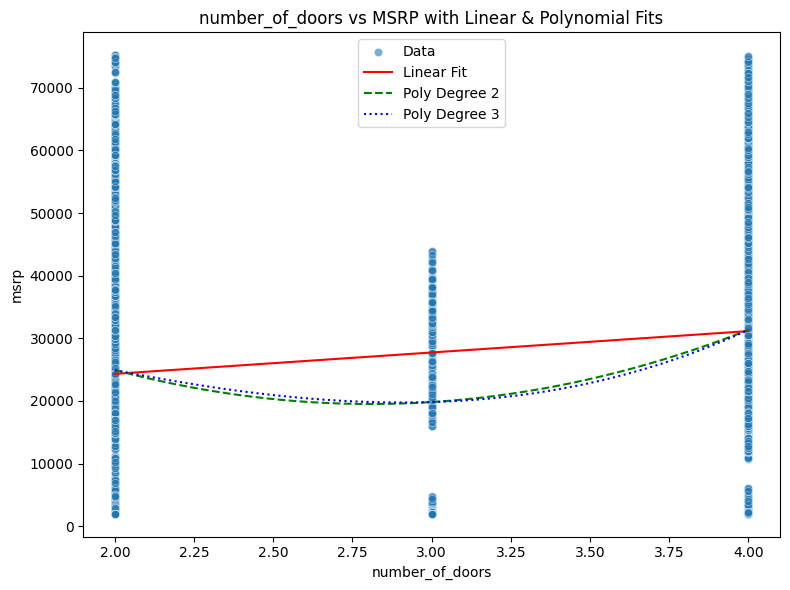

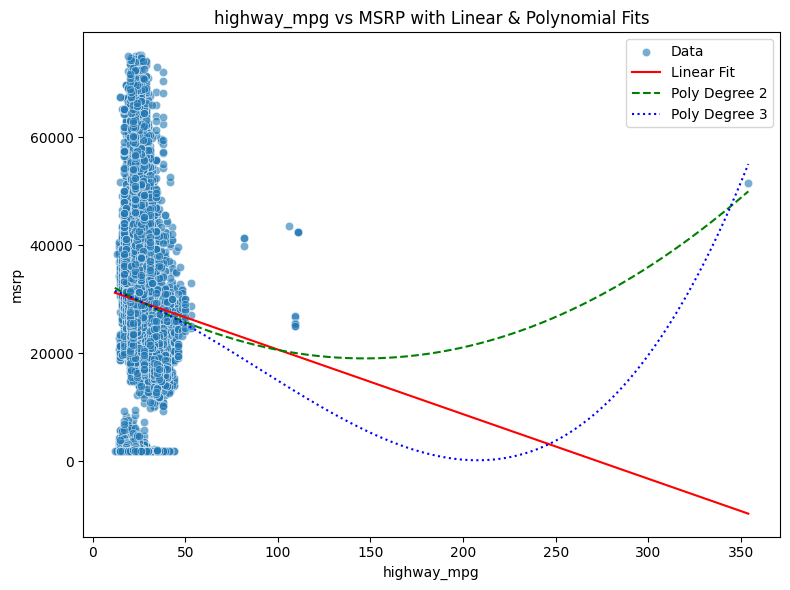

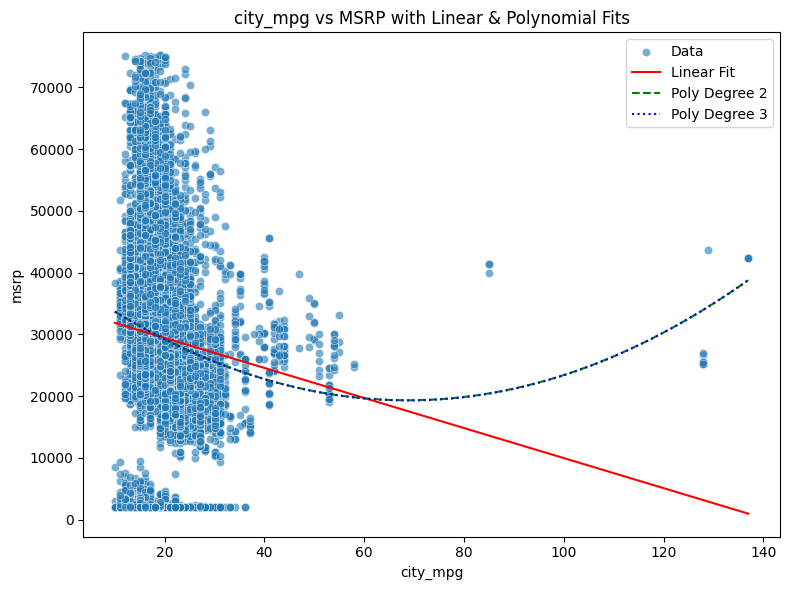

In [ ]:


for column in df_nums.columns[:-2]:
    df_sub = df_nums[[column, "msrp"]].dropna()
    X = df_sub[[column]].values
    y = df_sub["msrp"].values

    x_range = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)

    lin_reg = LinearRegression().fit(X, y)
    y_lin_pred = lin_reg.predict(x_range)

    poly2 = PolynomialFeatures(degree=2)
    X_poly2 = poly2.fit_transform(X)
    lin_reg2 = LinearRegression().fit(X_poly2, y)
    y_poly2_pred = lin_reg2.predict(poly2.transform(x_range))

    poly3 = PolynomialFeatures(degree=3)
    X_poly3 = poly3.fit_transform(X)
    lin_reg3 = LinearRegression().fit(X_poly3, y)
    y_poly3_pred = lin_reg3.predict(poly3.transform(x_range))

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X.flatten(), y=y, label="Data", alpha=0.6)
    plt.plot(x_range, y_lin_pred, color="red", label="Linear Fit")
    plt.plot(x_range, y_poly2_pred, color="green", linestyle='--', label="Poly Degree 2")
    plt.plot(x_range, y_poly3_pred, color="blue", linestyle=':', label="Poly Degree 3")

    plt.xlabel(column)
    plt.ylabel("msrp")
    plt.title(f"{column} vs MSRP with Linear & Polynomial Fits")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
c_table = df_nums.corr()
fig4 = px.imshow(c_table, text_auto=True, color_continuous_scale='RdBu_r', title='Correlation Heatmap', width=800, height=800)
fig4.update_traces(textfont_size=9.5)
fig4.show()

# Thiết lập mô hình pipeline

In [ ]:
target = "msrp"
X = df.drop(columns=[target])
y = df[target]

In [ ]:
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
print("Numerical:", num_cols)
print("Categorical:", cat_cols)

Numerical: ['year', 'engine_hp', 'engine_cylinders', 'number_of_doors', 'highway_mpg', 'city_mpg', 'popularity']
Categorical: ['make', 'model', 'engine_fuel_type', 'transmission_type', 'driven_wheels', 'vehicle_size', 'vehicle_style']


In [ ]:
# hyper parameters
_precision = 7
_pca = .90
_test_size = .2 # 20% of the data is in the test set
_scaler = "standard" # or MinMaxScaler

In [ ]:
if(_scaler == "standard") :
  num_pipe = Pipeline([
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', StandardScaler())
  ])
else :
  num_pipe = Pipeline([
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', MinMaxScaler(feature_range=(0,1)))
  ])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

In [ ]:
pca = PCA(n_components=_pca, svd_solver='covariance_eigh') # or arpack

In [ ]:
# Regression models
models_list = {
    "Linear Regression": LinearRegression(), #0.3s
    "Lasso Regression": Lasso(alpha=0.01), #0.3s
    "Logistic Regression": LogisticRegression(max_iter=1000), # idk why this fails
    "Random Forest Regressor, n=50": RandomForestRegressor(n_estimators=50, random_state=42), #30s
    "Random Forest Regressor, n=100": RandomForestRegressor(n_estimators=100, random_state=42), #1m
    "Support Vector Regressor": SVR(kernel='rbf'), #4s
    "KNN Regressor, k=5": KNeighborsRegressor(n_neighbors=5), #0.2s
    "KNN Regressor, k=10": KNeighborsRegressor(n_neighbors=10), #0.2s
    "KNN Regressor, k=50": KNeighborsRegressor(n_neighbors=50), #0.2s
}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=_test_size, random_state=RANDOM_STATE)

# Chạy mô hình

Training Linear Regression
Finished training in 0.3066 seconds


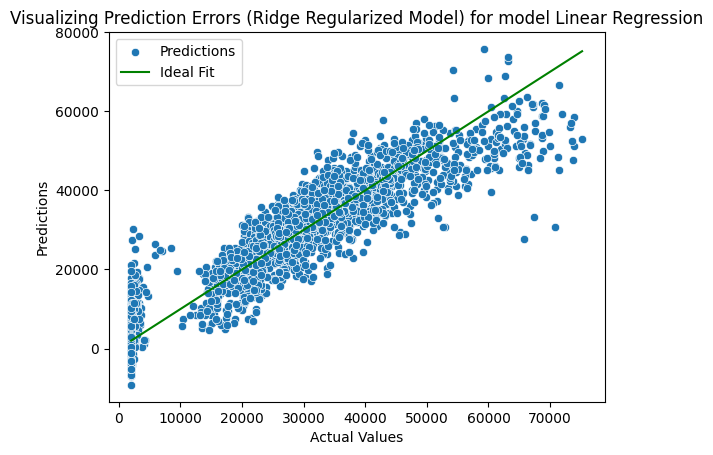

Training Lasso Regression
Finished training in 0.3075 seconds


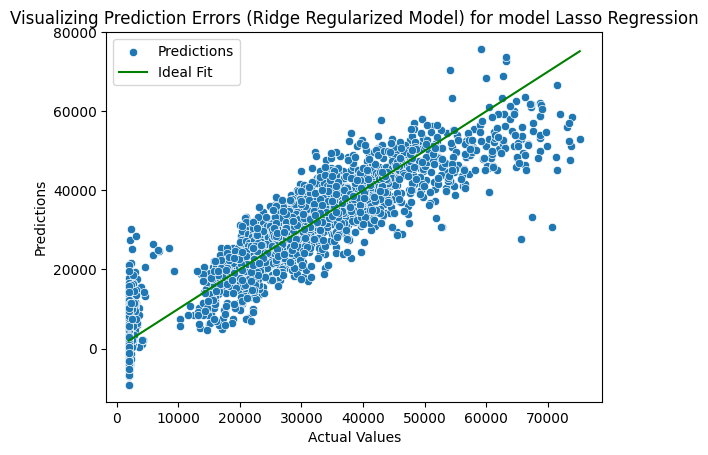

Training Logistic Regression
Finished training in 172.4809 seconds


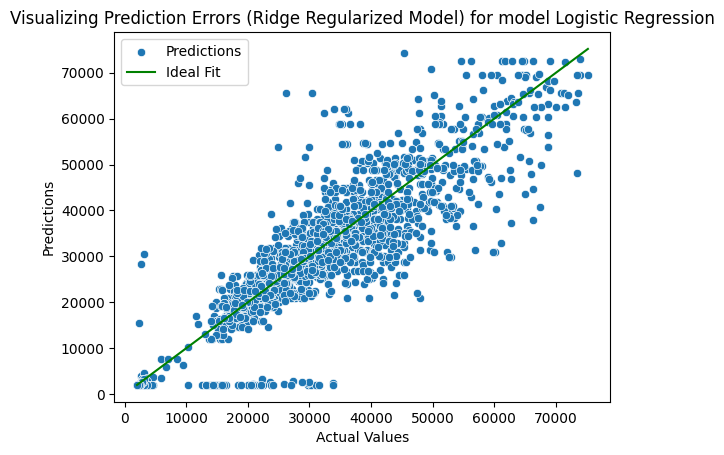

Training Random Forest Regressor, n=50
Finished training in 27.6347 seconds


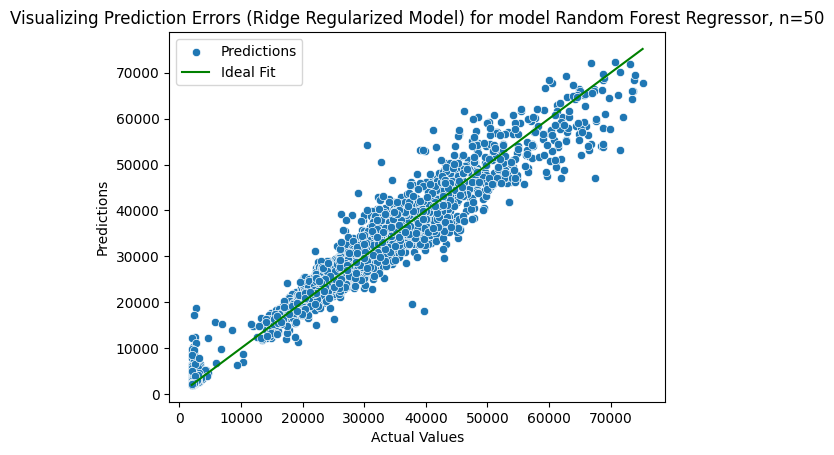

Training Random Forest Regressor, n=100
Finished training in 47.5501 seconds


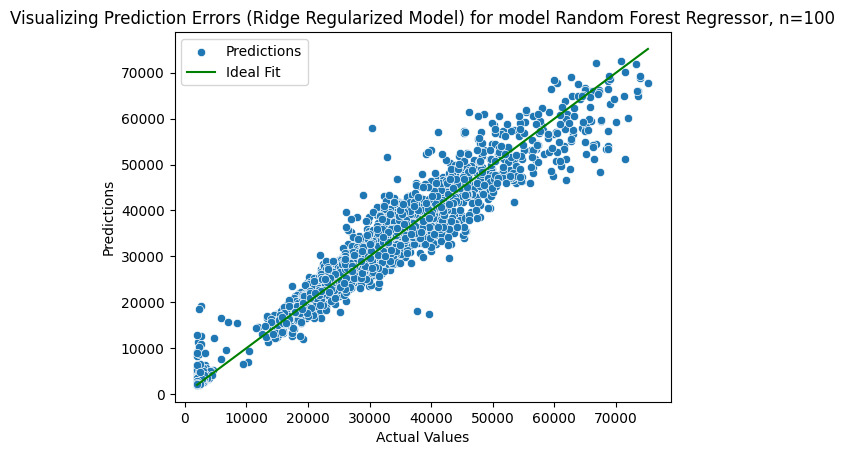

Training Support Vector Regressor
Finished training in 5.0795 seconds


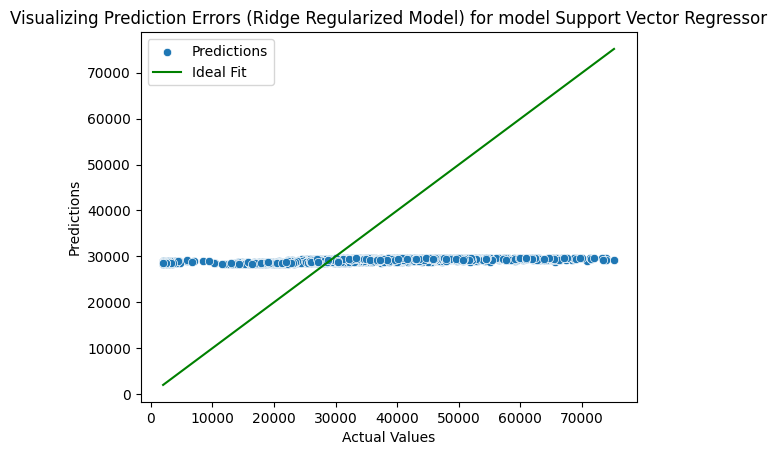

Training KNN Regressor, k=5
Finished training in 0.9280 seconds


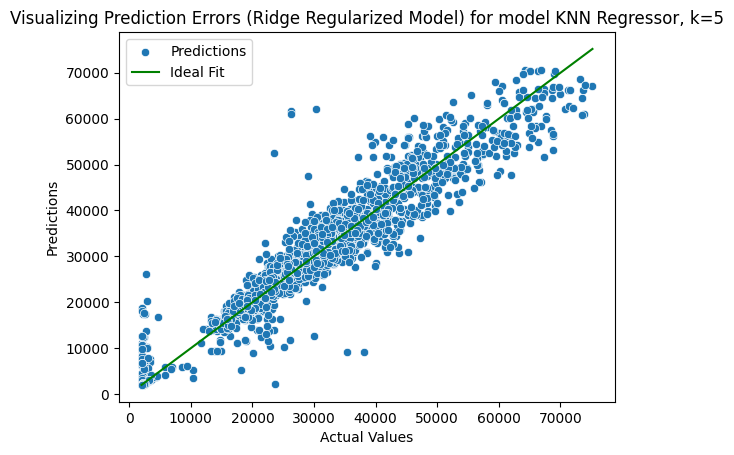

Training KNN Regressor, k=10
Finished training in 0.3137 seconds


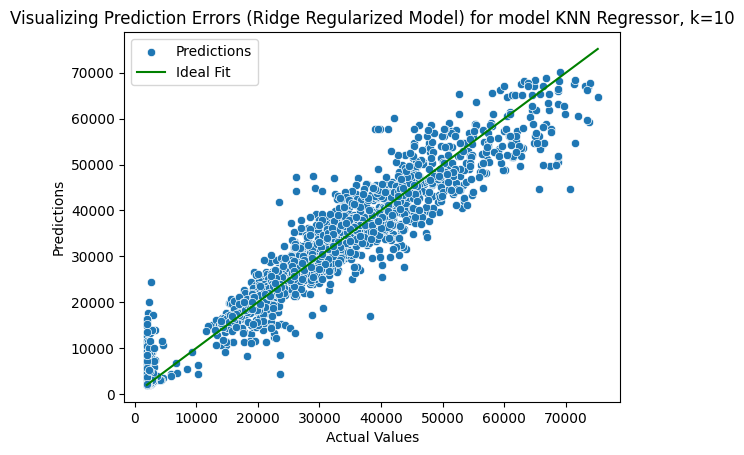

Training KNN Regressor, k=50
Finished training in 0.7656 seconds


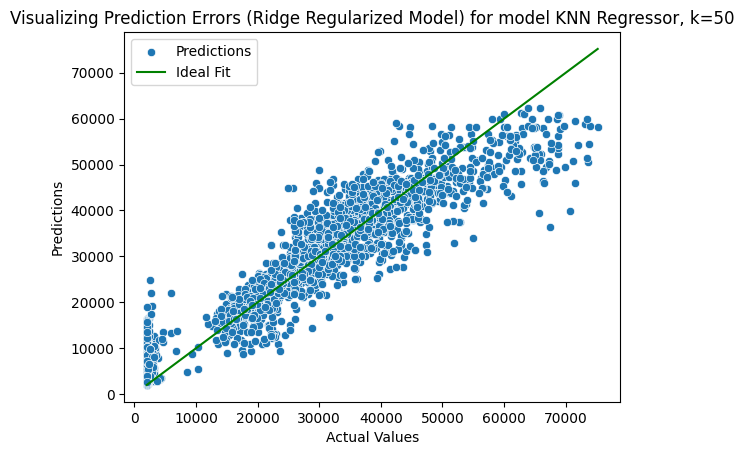

,model,train_mse,train_r2,test_mse,test_r2
0,Linear Regression,4.539609e+07,4.539609e+07,4.541036e+07,0.8200782
1,Lasso Regression,4.539609e+07,4.539609e+07,4.541033e+07,0.8200783
2,Logistic Regression,4.543764e+07,4.543764e+07,5.003081e+07,0.8017714
3,"Random Forest Regressor, n=50",5.11082e+06,5.11082e+06,1.589508e+07,0.9370216
4,"Random Forest Regressor, n=100",5.031674e+06,5.031674e+06,1.609901e+07,0.9362136
5,Support Vector Regressor,2.444992e+08,2.444992e+08,2.433881e+08,0.03566441
6,"KNN Regressor, k=5",1.186902e+07,1.186902e+07,2.042296e+07,0.9190815
7,"KNN Regressor, k=10",1.743508e+07,1.743508e+07,2.193432e+07,0.9130934
8,"KNN Regressor, k=50",3.452275e+07,3.452275e+07,3.51762e+07,0.8606273


In [ ]:
import time

# fit models
model_scores = []
for name, model in models_list.items():
    start_time = time.perf_counter()
    print("Training "+ name)
    clf = Pipeline([
        ('preproc', preprocessor),
        ('pca', pca),
        ('model', model)
    ])

    clf.fit(X_train, y_train)

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print(f"Finished training in {elapsed_time:.4f} seconds")
    # train predictions
    # Predict on train set
    y_train_pred = clf.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)


    # Predict on test set
    y_test_pred = clf.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    thisModelScores = [
          # Statistical metrics
          mse_train,
          mse_train,
          mse_test,
          r2_test,
        ]

    thisModelScores = [f"{x:.{_precision}}" for x in thisModelScores]
    thisModelScores.insert(0, name)
    model_scores.append(thisModelScores)

    # graph predictions
    plt.figure()
    sns.scatterplot(x=y_test, y=y_test_pred, label="Predictions")
    sns.lineplot(x=y_test, y=y_test, color="g", label="Ideal Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predictions")
    plt.title(f"Visualizing Prediction Errors (Ridge Regularized Model) for model {name}")
    plt.show()


#Outside train loop
model_scores = pd.DataFrame(model_scores)
model_scores.columns = [
      "model",

      "train_mse",
      "train_r2",
      "test_mse",
      "test_r2",
    ]
model_scores


# Kết luận

+ Model Random Forest (n=50) có MSE thấp nhất, thấp hơn phiên bản n = 100. Điều này cho thấy có nhiều cây hơn có thể overfit set train và không hẳn luôn tốt hơn.

+ Model KNN trở nên tệ hơn khi k lên cao với k=5 có kết quả tốt nhất.

+ Model Tuyến tính (Linear) và Lasso regression có kết quả tương tự nhau.

+ Model Random forest có kết quả vượt hẳn các model khác, điều này cho thấy dữ liệu có nhiều quan hệ phức tạp không tuyến tính mà cấu trúc decision tree thể hiện tốt.

+ Train MSE cho Model Random forrest thấp hơn hẳn so với các model khác, cho thấy Model này không dễ bị overfit.

+ Model Logistric Regression không phù hợp cho trường hợp này, dẫn đến lỗi cao cho cả train và test.

+ Model Support Vector Regression không phù hợp với dataset nàyv với r rất cao.